# Assignment 4: Neural Machine Translation 
### Author: Ou, Dongwen
### Student ID: 15220212202866

In [68]:
def read_data_nmt():
    """读取英中翻译数据，只保留前两列"""
    path = '/Users/dongwenou/Downloads/Deep Learning files/NLP & LLM/cmn-eng/cmn.txt'
    lines = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                lines.append('\t'.join(parts[:2]))  # 只保留英中两列
    return '\n'.join(lines)

In [70]:
my_txt = read_data_nmt()

In [72]:
def preprocess_nmt(text):
    def no_space(char, prev_char): # 用于判断当前字符前面是否缺少空格
        return char in set(',.!?') and prev_char != ' ' # 如果当前字符是标点（, . ! ?）并且前面不是空格，则返回 True，说明需要补空格

    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # '\u202f' 和 '\xa0' 是 非标准空格字符（常见于网页、PDF、Unicode 文件中）：
    # \u202f: 窄不间断空格（Narrow No-Break Space）
	# \xa0: 不间断空格（No-Break Space）
	# 将它们统一替换为普通空格 ' '，防止句子连接错误。
   
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char  
           for i, char in enumerate(text)] # 如果 i > 0 且当前字符是标点（如 . ! ?），且前一个字符不是空格，就在前面加空格。
    return ''.join(out) # 把字符列表拼接成一个新的字符串

text = preprocess_nmt(my_txt)
print(text[:500])

hi .	嗨。
hi .	你好。
run .	你用跑的。
stop !	住手！
wait !	等等！
wait !	等一下！
begin .	开始！
hello !	你好。
i try .	我试试。
i won !	我赢了。
oh no !	不会吧。
cheers !	乾杯 !
got it ?	知道了没有？
got it ?	懂了吗？
got it ?	你懂了吗？
he ran .	他跑了。
hop in .	跳进来。
i know .	我知道。
i quit .	我退出。
i quit .	我不干了。
i'm ok .	我沒事。
i'm up .	我已经起来了。
listen .	听着。
no way !	不可能！
no way !	没门！
really ?	真的？
really ?	你确定？
thanks !	谢谢！
try it .	试试吧。
we try .	我们来试试。
why me ?	为什么是我？
ask tom .	去问汤姆。
awesome !	好棒！
be calm .	冷静点。
be fair .	公平点。
be kind .	友善点。
be kind .	友好


In [236]:
# 在單字的基礎上tokenize
def tokenize_nmt(text, num_examples=None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i >= num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].lower().split(' '))  # 英文分词
            target.append(list(parts[1]))               # 中文逐字
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['hi', '.'],
  ['hi', '.'],
  ['run', '.'],
  ['stop', '!'],
  ['wait', '!'],
  ['wait', '!']],
 [['嗨', '。'],
  ['你', '好', '。'],
  ['你', '用', '跑', '的', '。'],
  ['住', '手', '！'],
  ['等', '等', '！'],
  ['等', '一', '下', '！']])

In [300]:
# 在词的基础上划分
import jieba

def tokenize_nmt(text, num_examples=None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i >= num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].lower().split(' '))  # 英文空格分词
            target.append(list(jieba.cut(parts[1])))    # 中文词级分词
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['hi', '.'],
  ['hi', '.'],
  ['run', '.'],
  ['stop', '!'],
  ['wait', '!'],
  ['wait', '!']],
 [['嗨', '。'],
  ['你好', '。'],
  ['你', '用', '跑', '的', '。'],
  ['住手', '！'],
  ['等等', '！'],
  ['等', '一下', '！']])

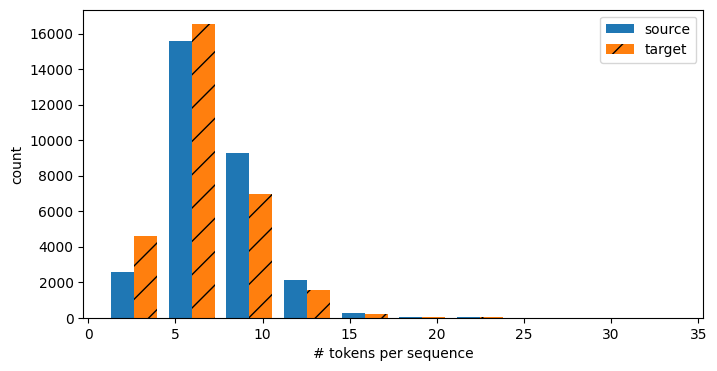

In [302]:
import matplotlib.pyplot as plt

def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist): # legend: 图例标签，例如 ['source', 'target']
    """Draw a histogram of list length pairs"""
    plt.figure(figsize=(8, 4))

    # Create histogram
    _, _, patches = plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])  # [len(l) for l in xlist]：将 xlist 中的每个句子转换为他的长度（单词数）
                                                             # 最终 plt.hist([[...], [...]]]) 画出两个直方图，自动重叠对比显示
    # _: bin edges（不需要用）
	# _: histogram values（也不用）
	# patches: 每组柱子对象（用于后续填充图案）
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add hatch pattern to the second set of bars
    for patch in patches[1].patches: # patches[1]: 指的是第二组柱子（即 target 的），.patches: 是每个柱子的对象
        patch.set_hatch('/')

    plt.legend(legend)
    plt.show()

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                       'count', source, target)

In [304]:
import collections
from collections import defaultdict, Counter

class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):  
        # tokens：二维 token 序列（如 [["i", "am"], ["you", "are"]]）
		# min_freq：最小词频过滤（频率低于该值的 token 不加入词表）
		# reserved_tokens：保留的特殊符号（如 <pad>、<bos>）
        
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []  # 确保默认值是列表而不是 None
        # 按出现频率排序
        counter = count_corpus(tokens) # 字典类似
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True) # key用来指定“按什么排序/比较”，reverse=True：按词频降序排列
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens # 索引 → token 的列表（第 0 个永远是 <unk>）
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx: # 对于频率 ≥ min_freq 且不在保留词里的 token：加入词表，更新索引映射
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token) # list长度

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)): # 如果 tokens 不是列表或元组，那就是传入了一个单个词（字符串）
            return self.token_to_idx.get(tokens, self.unk) # dict.get(key, default) 是 Python 字典的安全查找方法
                                                           # 如果 token 存在 → 返回它的索引；如果 token 不存在（OOV）→ 返回 self.unk（索引 0）
        return [self.__getitem__(token) for token in tokens] # 对每个 token 递归地调用 __getitem__()（即本函数自身）
# 功能：
# 输入单个词或一组词，返回对应索引或索引列表
# 未登录词（不在词表中的）返回 <unk> 的索引 0
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property # 是一个装饰器，用于将 类的方法变成一个只读属性：调用时不需要加括号 ()，让你像访问变量一样访问方法的返回值。
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs
# self._token_freqs 是一个私有属性（以单下划线开头，表示“内部使用”），而 token_freqs 则是对外的公有接口。

def count_corpus(tokens):
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list): # 如果第一项是 list，说明是二维结构 → 需要展平
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
  # 等价于 flat = []
  #       for line in tokens:
  #           for token in line:
  #               flat.append(token)
    return collections.Counter(tokens) # 输出：每个词元（token）的出现频率统计（返回一个 Counter 对象）

In [306]:
src_vocab = Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>']) # source: 是之前已经分词好的英文句子列表（二维 list，每句是一个词 list）
print(list(src_vocab.token_to_idx.items())[:10])
len(src_vocab)

[('<unk>', 0), ('<pad>', 1), ('<bos>', 2), ('<eos>', 3), ('.', 4), ('the', 5), ('i', 6), ('to', 7), ('you', 8), ('a', 9)]


4610

In [308]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列：将一个 token 序列 line 调整为固定长度 num_steps
       如果太长就截断，太短就用 padding_token 填充到指定长度"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[1464, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [310]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def build_array_nmt(lines, vocab, num_steps):
    '''
    将一个 token 序列（如 source 或 target）转换为：填充或截断到固定长度的二维数组
	计算每行的“有效长度”（即非 <pad> token 的数量）
    '''
    lines = [vocab[l] for l in lines] # l 是一个单词列表，整句变为索引列表
    lines = [l + [vocab['<eos>']] for l in lines] # 在每个句子末尾加上 <eos>
    array = np.array([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines]) # 填充/裁剪
    valid_len = (array != vocab['<pad>']).astype(np.int32).sum(1) # .astype(np.int32) 将其转换为 0/1 矩阵；.sum(1) 沿行求和，得到每句真实 token 数
    return array, valid_len

def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and vocabulary for the translation dataset"""
    # Read and preprocess data
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)

    # Create vocabularies (using our custom Vocab class)
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])

    # Convert text to numerical arrays 将每个句子变成固定长度的索引数组，并计算有效长度
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)

    # Create dataset and iterator
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    dataset = TensorDataset(*[torch.tensor(array) for array in data_arrays]) # *把多个张量打包成一个可迭代的数据集，即 TensorDataset；
    # 访问 dataset[i] 会返回一个 tuple：(src_array[i], src_valid_len[i], tgt_array[i], tgt_valid_len[i])
    data_iter = DataLoader(dataset, batch_size, shuffle=True) # PyTorch 的 数据迭代器 DataLoader

    return data_iter, src_vocab, tgt_vocab

In [312]:
import numpy as np
from torch import nn
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.numpy().astype(np.int32))
    print('X的有效长度:', X_valid_len.numpy())
    print('Y:', Y.numpy().astype(np.int32))
    print('Y的有效长度:', Y_valid_len.numpy())
    break

X: [[ 89 200   4   3   1   1   1   1]
 [ 18   0   4   3   1   1   1   1]]
X的有效长度: [4 4]
Y: [[  0   0   0   4   3   1   1   1]
 [129  33   4   3   1   1   1   1]]
Y的有效长度: [5 4]


In [314]:
from torch import nn
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError # 这里不实现逻辑，表示这是“模板”，子类必须实现自己的 forward() 逻辑

In [316]:
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [318]:
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [320]:
class Seq2SeqEncoder(Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size), num_steps is the length
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步，PyTorch 的 nn.GRU、nn.LSTM 要求输入张量的默认维度是：(seq_len, batch_size, input_size)
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [322]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)#batch_size = 4, num_steps = 7
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [324]:
class Seq2SeqDecoder(Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout) # 因为 解码器的每个输入除了当前词的嵌入（embed_size）之外，还需要上下文向量（num_hiddens） —— 也就是从编码器传来的状态，表示源句的全局信息。
        self.dense = nn.Linear(num_hiddens, vocab_size) # 输出映射到 vocab 空间（用于 softmax 分类）

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1] # 编码器输出是 (output, state)，这里只取 state 作为解码器的初始状态。

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        # state[-1]: 最后一层的隐状态，形状为 (batch_size, num_hiddens)
        # 扩为3-dimension，然后第一个维度复制 X.shape[0]这么多次，其余1表示不变
        X_and_context = torch.cat((X, context), 2) # 2表示dim=2，按最后一个维度cat
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [326]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [328]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项：在 loss 计算中“屏蔽无效位置”（padding 的地方）"""
    maxlen = X.size(1) 
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None] 
    # [None, :]相当于.unsqueeze(0), 在结果的第0维增加一个维度；所以(1,maxlen)<(valid_len,1)，广播为(maxlen,valid_len)比较
    # 这个布尔矩阵就表示每个样本在哪些时间步是「合法 token」，哪些是 padding
    X[~mask] = value # 把 True 变成 False，False 变成 True；把true的位置赋值为value，也就是本来为mask中的false也就是padding的位置
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))#valid_len[:, None] =tensor([[1],
                                                                  #[2]]) 0,1,2 < 1; 0,1,2, < 2.

tensor([[1, 0, 0],
        [4, 5, 0]])

In [330]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)  # 构建 shape 和 label 一样的全 1 张量
        weights = sequence_mask(weights, valid_len) # 将超过 valid_len 的位置设为 0，其余仍为 1
        self.reduction='none' # nn.CrossEntropyLoss 默认是 'mean'，即对所有 token 求平均；这里我们需要每个 token 的单独 loss 值，因此用 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label) 
        # nn.CrossEntropyLoss 要求输入是 (batch_size, vocab_size, num_steps)
        # 输出 unweighted_loss 是 (batch_size, num_steps)，每个 token 的交叉熵值
        weighted_loss = (unweighted_loss * weights).mean(dim=1) # 把遮蔽位置的 loss 乘以 0 → 屏蔽掉了，只对有效位置保留 loss，最后对时间步（dim=1）取平均，得到每个样本的 loss
        return weighted_loss

In [332]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型，net是一个EncoderDecoder对象"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight) # 对一个张量进行 Xavier 均匀分布初始化
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights) # apply() 将初始化函数应用到每一层。
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()

    # Initialize plot
    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xlim([10, num_epochs]) # 表示 x 轴的范围下限为 10，上限为 num_epochs
    losses = []

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0
        total_tokens = 0

        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch] # 所有张量转到 GPU/CPU
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1) # 一列样本量的bos
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  
            # 强制教学：我们不使用模型自己的预测结果，而是强行使用真实答案（ground truth）中的上一个 token 作为当前输入
            Y_hat, _ = net(X, dec_input, X_valid_len)  # net() 进行 encoder-decoder 前向传播 = net.forward(enc_X=X, dec_X=dec_input, *args=[X_valid_len])
            l = loss(Y_hat, Y, Y_valid_len) # loss() 只对非 padding token 计算交叉熵。
            l.sum().backward()      # 损失函数的标量进行“反向传播”

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1) # 裁剪范数超过 1 的梯度

            num_tokens = Y_valid_len.sum()
            optimizer.step()  # step() 更新参数

            with torch.no_grad():
                total_loss += l.sum().item() # .item(): 把这个单元素 tensor 转换成 Python 的 float 数字
                total_tokens += num_tokens.item()

        avg_loss = total_loss / total_tokens
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            # Update plot
            plt.plot(range(10, epoch + 2, 10), losses[9::10], 'b-')
            plt.pause(0.1)

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch + 1}, loss {avg_loss:.3f}, {total_tokens / epoch_time:.1f} '
              f'tokens/sec on {str(device)}')

    plt.show()
    print(f'Final loss: {losses[-1]:.3f}')

Epoch 1, loss 0.467, 32662.3 tokens/sec on cpu
Epoch 2, loss 0.359, 33696.2 tokens/sec on cpu
Epoch 3, loss 0.336, 37526.8 tokens/sec on cpu
Epoch 4, loss 0.323, 32010.3 tokens/sec on cpu
Epoch 5, loss 0.309, 31968.3 tokens/sec on cpu
Epoch 6, loss 0.294, 37543.2 tokens/sec on cpu
Epoch 7, loss 0.280, 36297.3 tokens/sec on cpu
Epoch 8, loss 0.267, 34138.9 tokens/sec on cpu
Epoch 9, loss 0.255, 33634.0 tokens/sec on cpu


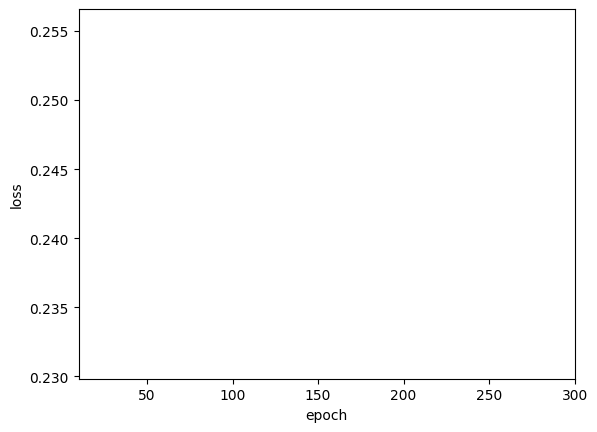

Epoch 10, loss 0.243, 9228.9 tokens/sec on cpu
Epoch 11, loss 0.232, 35024.2 tokens/sec on cpu
Epoch 12, loss 0.223, 31956.4 tokens/sec on cpu
Epoch 13, loss 0.213, 38461.5 tokens/sec on cpu
Epoch 14, loss 0.204, 33493.6 tokens/sec on cpu
Epoch 15, loss 0.195, 35626.3 tokens/sec on cpu
Epoch 16, loss 0.188, 34880.0 tokens/sec on cpu
Epoch 17, loss 0.181, 32678.8 tokens/sec on cpu
Epoch 18, loss 0.173, 33666.2 tokens/sec on cpu
Epoch 19, loss 0.166, 33463.2 tokens/sec on cpu


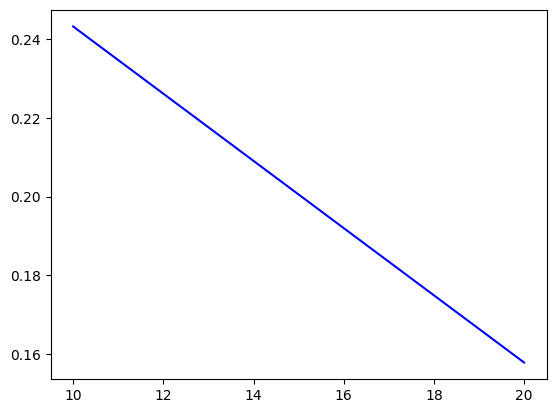

Epoch 20, loss 0.158, 14299.3 tokens/sec on cpu
Epoch 21, loss 0.153, 32779.0 tokens/sec on cpu
Epoch 22, loss 0.148, 35528.7 tokens/sec on cpu
Epoch 23, loss 0.142, 35611.9 tokens/sec on cpu
Epoch 24, loss 0.136, 35481.6 tokens/sec on cpu
Epoch 25, loss 0.131, 26144.0 tokens/sec on cpu
Epoch 26, loss 0.128, 33340.0 tokens/sec on cpu
Epoch 27, loss 0.124, 34394.0 tokens/sec on cpu
Epoch 28, loss 0.119, 34702.1 tokens/sec on cpu
Epoch 29, loss 0.115, 36123.0 tokens/sec on cpu


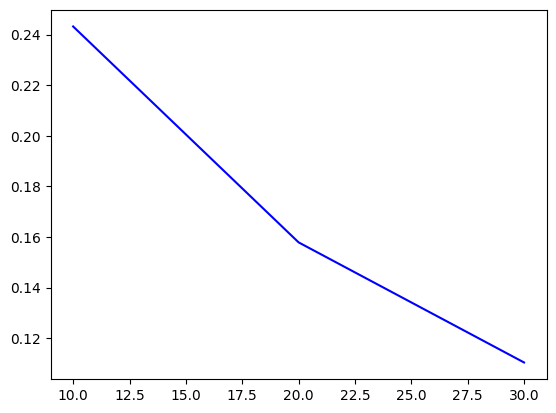

Epoch 30, loss 0.110, 13684.0 tokens/sec on cpu
Epoch 31, loss 0.106, 35272.5 tokens/sec on cpu
Epoch 32, loss 0.103, 33910.0 tokens/sec on cpu
Epoch 33, loss 0.098, 35471.3 tokens/sec on cpu
Epoch 34, loss 0.095, 35984.3 tokens/sec on cpu
Epoch 35, loss 0.093, 33724.0 tokens/sec on cpu
Epoch 36, loss 0.090, 32754.1 tokens/sec on cpu
Epoch 37, loss 0.087, 34179.4 tokens/sec on cpu
Epoch 38, loss 0.083, 33445.3 tokens/sec on cpu
Epoch 39, loss 0.082, 35935.3 tokens/sec on cpu


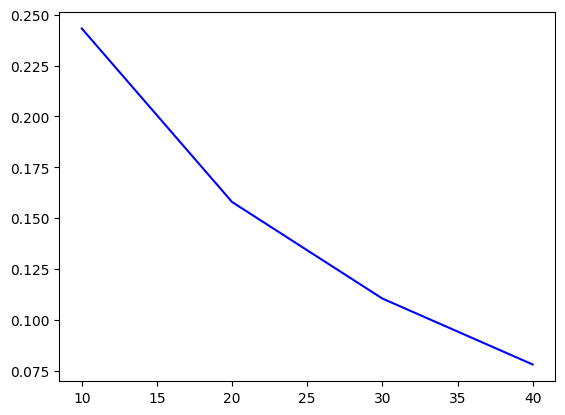

Epoch 40, loss 0.078, 13930.0 tokens/sec on cpu
Epoch 41, loss 0.078, 33934.1 tokens/sec on cpu
Epoch 42, loss 0.075, 34664.4 tokens/sec on cpu
Epoch 43, loss 0.072, 33390.3 tokens/sec on cpu
Epoch 44, loss 0.069, 33764.6 tokens/sec on cpu
Epoch 45, loss 0.069, 36548.4 tokens/sec on cpu
Epoch 46, loss 0.066, 36490.4 tokens/sec on cpu
Epoch 47, loss 0.064, 35441.9 tokens/sec on cpu
Epoch 48, loss 0.062, 34134.9 tokens/sec on cpu
Epoch 49, loss 0.061, 34781.2 tokens/sec on cpu


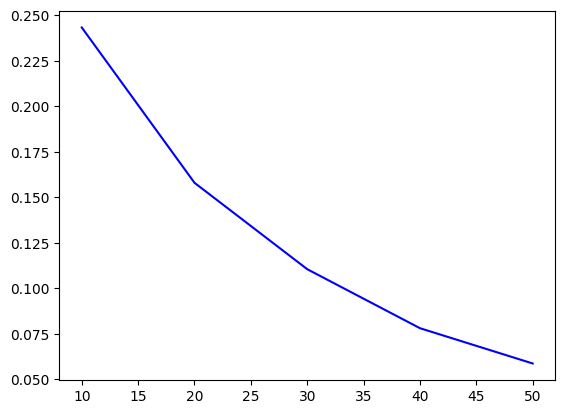

Epoch 50, loss 0.059, 13484.8 tokens/sec on cpu
Epoch 51, loss 0.057, 33433.3 tokens/sec on cpu
Epoch 52, loss 0.055, 35376.2 tokens/sec on cpu
Epoch 53, loss 0.055, 39946.7 tokens/sec on cpu
Epoch 54, loss 0.054, 36624.2 tokens/sec on cpu
Epoch 55, loss 0.052, 31139.8 tokens/sec on cpu
Epoch 56, loss 0.051, 35930.5 tokens/sec on cpu
Epoch 57, loss 0.051, 34161.9 tokens/sec on cpu
Epoch 58, loss 0.048, 35578.7 tokens/sec on cpu
Epoch 59, loss 0.048, 34905.2 tokens/sec on cpu


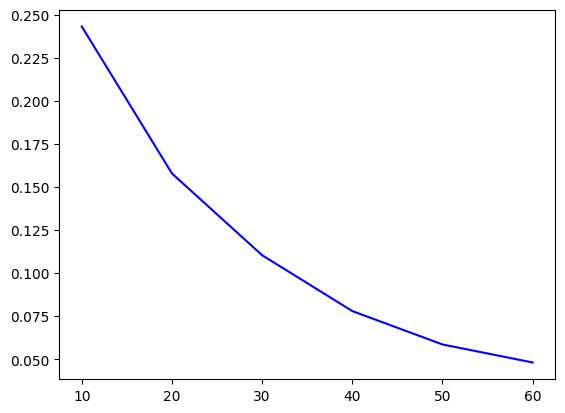

Epoch 60, loss 0.048, 13254.1 tokens/sec on cpu
Epoch 61, loss 0.046, 36297.7 tokens/sec on cpu
Epoch 62, loss 0.045, 35863.4 tokens/sec on cpu
Epoch 63, loss 0.043, 30712.6 tokens/sec on cpu
Epoch 64, loss 0.043, 33667.8 tokens/sec on cpu
Epoch 65, loss 0.042, 32318.7 tokens/sec on cpu
Epoch 66, loss 0.041, 26831.5 tokens/sec on cpu
Epoch 67, loss 0.039, 30076.0 tokens/sec on cpu
Epoch 68, loss 0.039, 29667.4 tokens/sec on cpu
Epoch 69, loss 0.037, 31520.2 tokens/sec on cpu


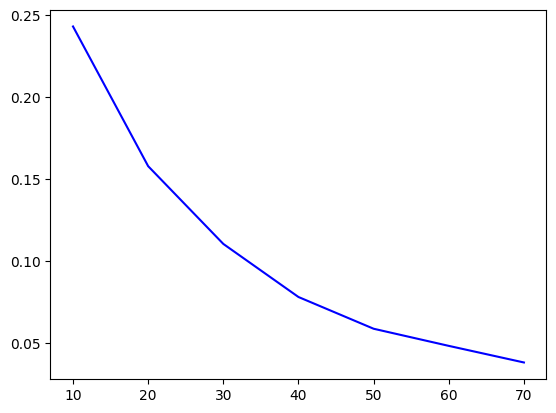

Epoch 70, loss 0.038, 13303.6 tokens/sec on cpu
Epoch 71, loss 0.036, 33464.5 tokens/sec on cpu
Epoch 72, loss 0.037, 34144.3 tokens/sec on cpu
Epoch 73, loss 0.036, 34914.6 tokens/sec on cpu
Epoch 74, loss 0.036, 35173.7 tokens/sec on cpu
Epoch 75, loss 0.036, 30809.8 tokens/sec on cpu
Epoch 76, loss 0.034, 29212.4 tokens/sec on cpu
Epoch 77, loss 0.034, 34375.8 tokens/sec on cpu
Epoch 78, loss 0.033, 32746.4 tokens/sec on cpu
Epoch 79, loss 0.033, 33174.1 tokens/sec on cpu


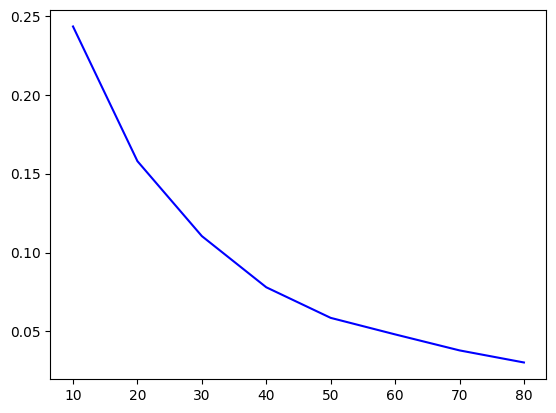

Epoch 80, loss 0.030, 13996.4 tokens/sec on cpu
Epoch 81, loss 0.032, 36333.3 tokens/sec on cpu
Epoch 82, loss 0.031, 34730.6 tokens/sec on cpu
Epoch 83, loss 0.031, 34698.0 tokens/sec on cpu
Epoch 84, loss 0.031, 31995.7 tokens/sec on cpu
Epoch 85, loss 0.029, 34908.0 tokens/sec on cpu
Epoch 86, loss 0.028, 35018.7 tokens/sec on cpu
Epoch 87, loss 0.030, 32435.0 tokens/sec on cpu
Epoch 88, loss 0.030, 34100.2 tokens/sec on cpu
Epoch 89, loss 0.029, 34870.6 tokens/sec on cpu


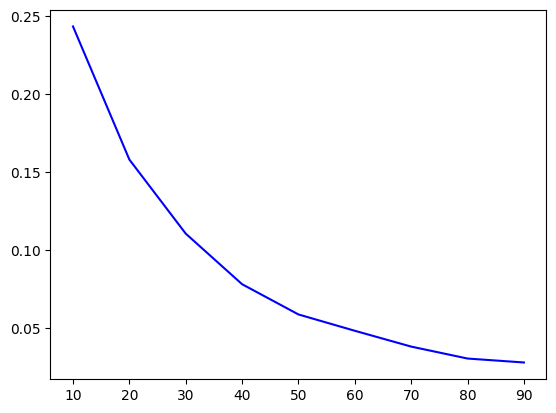

Epoch 90, loss 0.028, 13587.0 tokens/sec on cpu
Epoch 91, loss 0.026, 34124.0 tokens/sec on cpu
Epoch 92, loss 0.026, 33851.5 tokens/sec on cpu
Epoch 93, loss 0.027, 35526.8 tokens/sec on cpu
Epoch 94, loss 0.027, 33818.6 tokens/sec on cpu
Epoch 95, loss 0.027, 36540.5 tokens/sec on cpu
Epoch 96, loss 0.027, 34051.3 tokens/sec on cpu
Epoch 97, loss 0.024, 35996.1 tokens/sec on cpu
Epoch 98, loss 0.025, 36810.4 tokens/sec on cpu
Epoch 99, loss 0.026, 36458.6 tokens/sec on cpu


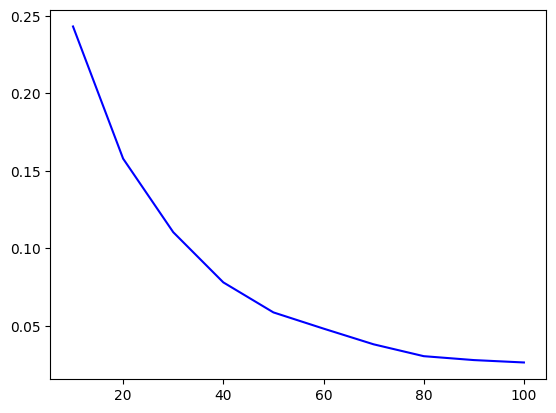

Epoch 100, loss 0.026, 13907.6 tokens/sec on cpu
Epoch 101, loss 0.024, 32785.9 tokens/sec on cpu
Epoch 102, loss 0.024, 32604.8 tokens/sec on cpu
Epoch 103, loss 0.026, 34791.5 tokens/sec on cpu
Epoch 104, loss 0.025, 35873.0 tokens/sec on cpu
Epoch 105, loss 0.024, 36934.6 tokens/sec on cpu
Epoch 106, loss 0.024, 31897.2 tokens/sec on cpu
Epoch 107, loss 0.024, 33339.7 tokens/sec on cpu
Epoch 108, loss 0.024, 31944.2 tokens/sec on cpu
Epoch 109, loss 0.023, 31680.7 tokens/sec on cpu


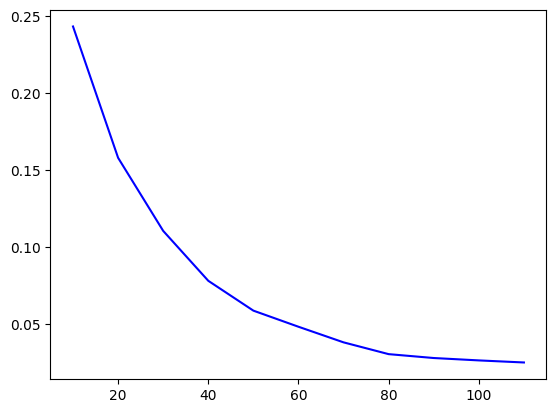

Epoch 110, loss 0.025, 13100.2 tokens/sec on cpu
Epoch 111, loss 0.024, 31613.9 tokens/sec on cpu
Epoch 112, loss 0.023, 32488.1 tokens/sec on cpu
Epoch 113, loss 0.023, 31219.7 tokens/sec on cpu
Epoch 114, loss 0.023, 32936.2 tokens/sec on cpu
Epoch 115, loss 0.022, 34742.3 tokens/sec on cpu
Epoch 116, loss 0.023, 31388.5 tokens/sec on cpu
Epoch 117, loss 0.022, 32257.2 tokens/sec on cpu
Epoch 118, loss 0.022, 31762.6 tokens/sec on cpu
Epoch 119, loss 0.022, 36475.9 tokens/sec on cpu


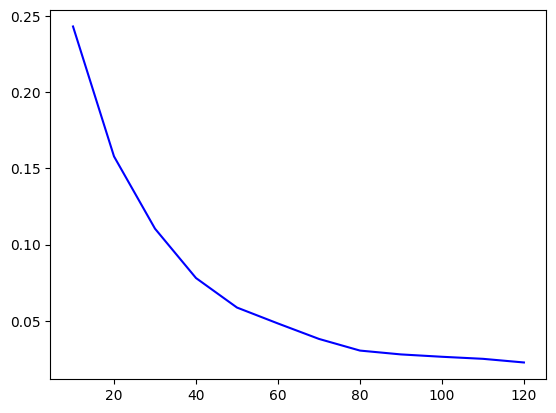

Epoch 120, loss 0.023, 13681.0 tokens/sec on cpu
Epoch 121, loss 0.022, 35618.0 tokens/sec on cpu
Epoch 122, loss 0.022, 34723.4 tokens/sec on cpu
Epoch 123, loss 0.021, 32254.5 tokens/sec on cpu
Epoch 124, loss 0.022, 35165.9 tokens/sec on cpu
Epoch 125, loss 0.022, 33304.2 tokens/sec on cpu
Epoch 126, loss 0.022, 32151.2 tokens/sec on cpu
Epoch 127, loss 0.021, 36974.7 tokens/sec on cpu
Epoch 128, loss 0.021, 33229.9 tokens/sec on cpu
Epoch 129, loss 0.021, 38898.8 tokens/sec on cpu


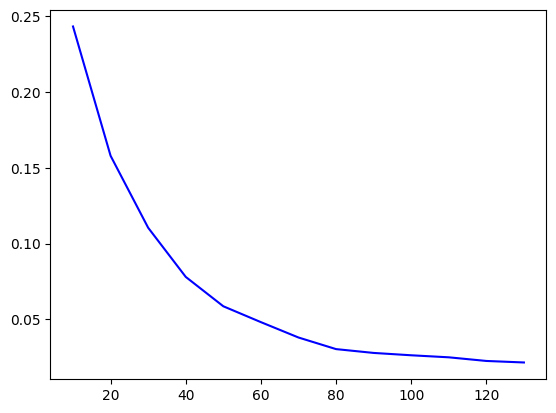

Epoch 130, loss 0.022, 13579.8 tokens/sec on cpu
Epoch 131, loss 0.021, 34962.8 tokens/sec on cpu
Epoch 132, loss 0.021, 35099.5 tokens/sec on cpu
Epoch 133, loss 0.019, 31318.2 tokens/sec on cpu
Epoch 134, loss 0.020, 31311.8 tokens/sec on cpu
Epoch 135, loss 0.020, 34755.0 tokens/sec on cpu
Epoch 136, loss 0.019, 31934.3 tokens/sec on cpu
Epoch 137, loss 0.020, 34869.5 tokens/sec on cpu
Epoch 138, loss 0.020, 34022.3 tokens/sec on cpu
Epoch 139, loss 0.021, 33028.1 tokens/sec on cpu


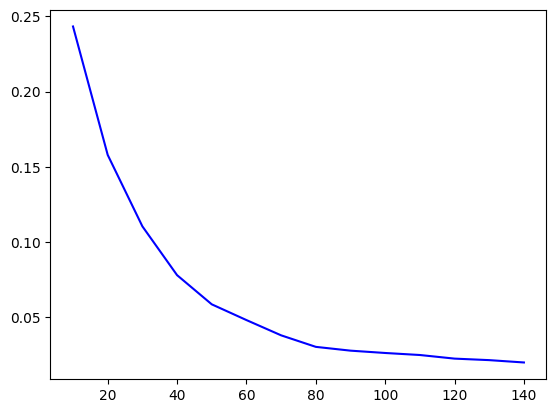

Epoch 140, loss 0.020, 13176.1 tokens/sec on cpu
Epoch 141, loss 0.020, 32679.3 tokens/sec on cpu
Epoch 142, loss 0.019, 33148.4 tokens/sec on cpu
Epoch 143, loss 0.020, 35198.7 tokens/sec on cpu
Epoch 144, loss 0.019, 32175.9 tokens/sec on cpu
Epoch 145, loss 0.020, 33850.1 tokens/sec on cpu
Epoch 146, loss 0.019, 33303.6 tokens/sec on cpu
Epoch 147, loss 0.020, 35061.7 tokens/sec on cpu
Epoch 148, loss 0.020, 34904.4 tokens/sec on cpu
Epoch 149, loss 0.021, 34607.0 tokens/sec on cpu


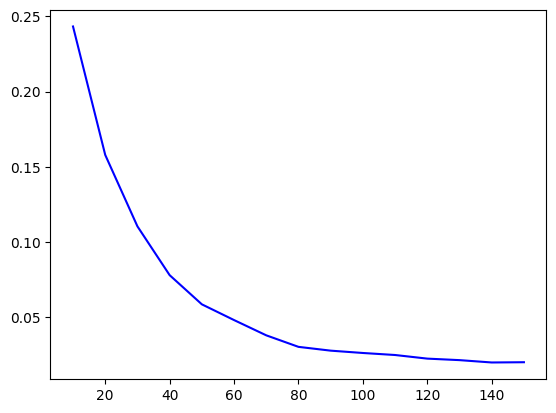

Epoch 150, loss 0.020, 13766.8 tokens/sec on cpu
Epoch 151, loss 0.020, 33769.1 tokens/sec on cpu
Epoch 152, loss 0.019, 35744.0 tokens/sec on cpu
Epoch 153, loss 0.020, 34024.8 tokens/sec on cpu
Epoch 154, loss 0.019, 33814.3 tokens/sec on cpu
Epoch 155, loss 0.018, 32610.6 tokens/sec on cpu
Epoch 156, loss 0.018, 33381.2 tokens/sec on cpu
Epoch 157, loss 0.018, 36272.6 tokens/sec on cpu
Epoch 158, loss 0.019, 36166.8 tokens/sec on cpu
Epoch 159, loss 0.019, 35564.2 tokens/sec on cpu


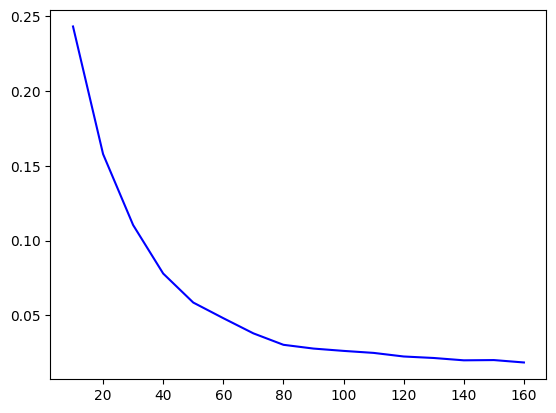

Epoch 160, loss 0.019, 13704.7 tokens/sec on cpu
Epoch 161, loss 0.018, 31571.3 tokens/sec on cpu
Epoch 162, loss 0.018, 31102.8 tokens/sec on cpu
Epoch 163, loss 0.019, 30005.4 tokens/sec on cpu
Epoch 164, loss 0.019, 32794.7 tokens/sec on cpu
Epoch 165, loss 0.018, 33551.8 tokens/sec on cpu
Epoch 166, loss 0.019, 33434.2 tokens/sec on cpu
Epoch 167, loss 0.018, 32977.9 tokens/sec on cpu
Epoch 168, loss 0.018, 30032.6 tokens/sec on cpu
Epoch 169, loss 0.017, 33701.5 tokens/sec on cpu


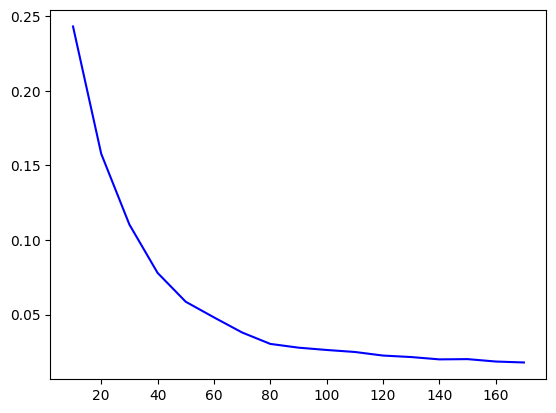

Epoch 170, loss 0.018, 13566.9 tokens/sec on cpu
Epoch 171, loss 0.017, 31589.5 tokens/sec on cpu
Epoch 172, loss 0.018, 34468.9 tokens/sec on cpu
Epoch 173, loss 0.018, 33870.8 tokens/sec on cpu
Epoch 174, loss 0.017, 33460.0 tokens/sec on cpu
Epoch 175, loss 0.018, 33047.9 tokens/sec on cpu
Epoch 176, loss 0.018, 32915.1 tokens/sec on cpu
Epoch 177, loss 0.017, 37299.7 tokens/sec on cpu
Epoch 178, loss 0.017, 36672.8 tokens/sec on cpu
Epoch 179, loss 0.018, 37012.0 tokens/sec on cpu


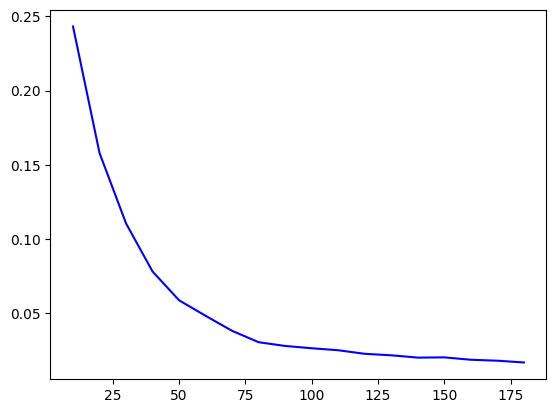

Epoch 180, loss 0.017, 13958.5 tokens/sec on cpu
Epoch 181, loss 0.018, 34099.2 tokens/sec on cpu
Epoch 182, loss 0.017, 33917.4 tokens/sec on cpu
Epoch 183, loss 0.017, 33014.4 tokens/sec on cpu
Epoch 184, loss 0.017, 32629.0 tokens/sec on cpu
Epoch 185, loss 0.017, 33323.5 tokens/sec on cpu
Epoch 186, loss 0.017, 35872.9 tokens/sec on cpu
Epoch 187, loss 0.016, 34949.6 tokens/sec on cpu
Epoch 188, loss 0.017, 33502.4 tokens/sec on cpu
Epoch 189, loss 0.018, 35099.1 tokens/sec on cpu


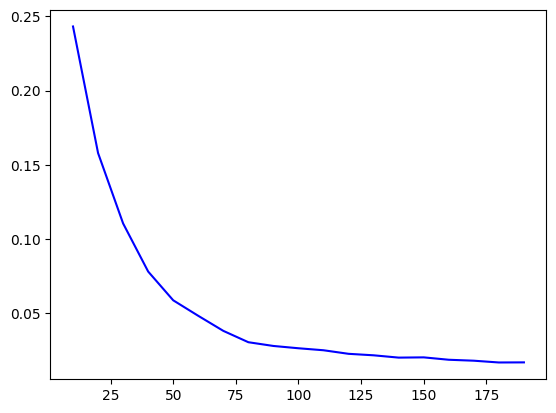

Epoch 190, loss 0.017, 13858.9 tokens/sec on cpu
Epoch 191, loss 0.017, 35506.3 tokens/sec on cpu
Epoch 192, loss 0.017, 34242.4 tokens/sec on cpu
Epoch 193, loss 0.017, 36818.2 tokens/sec on cpu
Epoch 194, loss 0.017, 35843.6 tokens/sec on cpu
Epoch 195, loss 0.017, 36616.7 tokens/sec on cpu
Epoch 196, loss 0.017, 35655.9 tokens/sec on cpu
Epoch 197, loss 0.017, 34409.4 tokens/sec on cpu
Epoch 198, loss 0.017, 35258.3 tokens/sec on cpu
Epoch 199, loss 0.017, 36073.6 tokens/sec on cpu


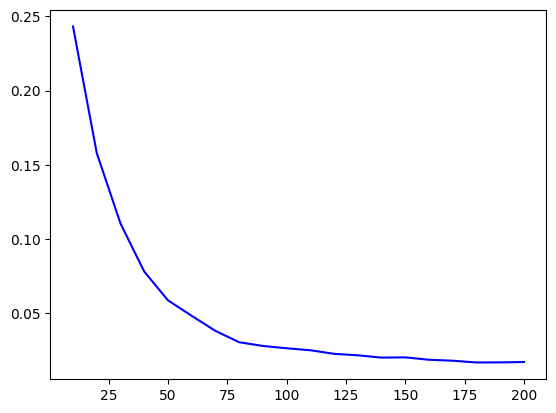

Epoch 200, loss 0.017, 13581.2 tokens/sec on cpu
Epoch 201, loss 0.017, 34145.2 tokens/sec on cpu
Epoch 202, loss 0.018, 38824.1 tokens/sec on cpu
Epoch 203, loss 0.017, 35399.8 tokens/sec on cpu
Epoch 204, loss 0.016, 36630.1 tokens/sec on cpu
Epoch 205, loss 0.017, 34854.6 tokens/sec on cpu
Epoch 206, loss 0.016, 33078.4 tokens/sec on cpu
Epoch 207, loss 0.016, 32628.9 tokens/sec on cpu
Epoch 208, loss 0.016, 36081.1 tokens/sec on cpu
Epoch 209, loss 0.017, 34341.8 tokens/sec on cpu


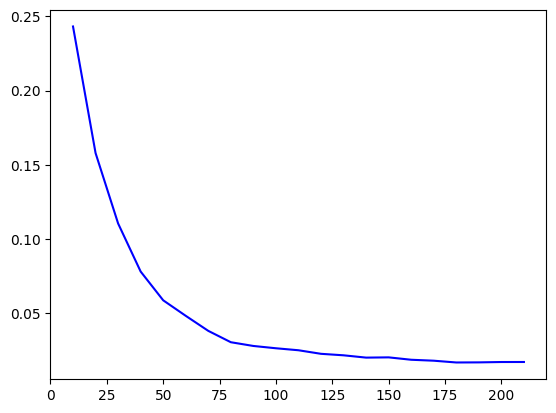

Epoch 210, loss 0.017, 13866.4 tokens/sec on cpu
Epoch 211, loss 0.017, 32405.9 tokens/sec on cpu
Epoch 212, loss 0.017, 38786.5 tokens/sec on cpu
Epoch 213, loss 0.016, 39397.4 tokens/sec on cpu
Epoch 214, loss 0.016, 35315.1 tokens/sec on cpu
Epoch 215, loss 0.016, 36194.5 tokens/sec on cpu
Epoch 216, loss 0.016, 35999.8 tokens/sec on cpu
Epoch 217, loss 0.017, 38277.2 tokens/sec on cpu
Epoch 218, loss 0.016, 35519.3 tokens/sec on cpu
Epoch 219, loss 0.016, 33711.1 tokens/sec on cpu


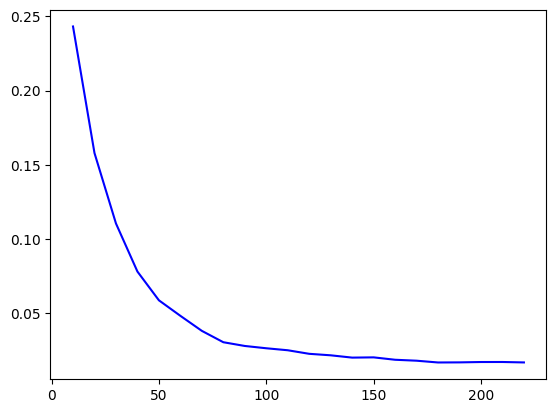

Epoch 220, loss 0.017, 14443.9 tokens/sec on cpu
Epoch 221, loss 0.015, 39281.7 tokens/sec on cpu
Epoch 222, loss 0.016, 38634.0 tokens/sec on cpu
Epoch 223, loss 0.016, 35030.6 tokens/sec on cpu
Epoch 224, loss 0.015, 36170.7 tokens/sec on cpu
Epoch 225, loss 0.016, 36153.0 tokens/sec on cpu
Epoch 226, loss 0.015, 35703.7 tokens/sec on cpu
Epoch 227, loss 0.015, 35492.4 tokens/sec on cpu
Epoch 228, loss 0.016, 36120.0 tokens/sec on cpu
Epoch 229, loss 0.016, 36046.0 tokens/sec on cpu


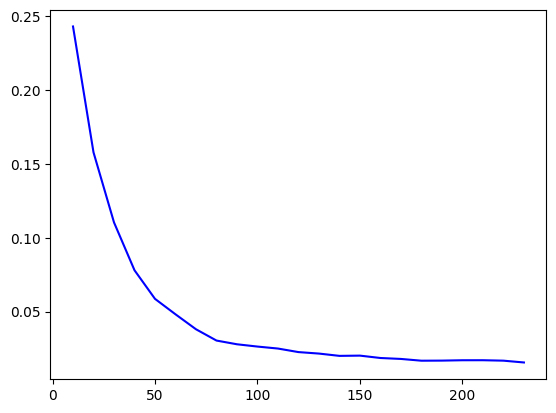

Epoch 230, loss 0.016, 13998.6 tokens/sec on cpu
Epoch 231, loss 0.015, 34050.7 tokens/sec on cpu
Epoch 232, loss 0.015, 36944.0 tokens/sec on cpu
Epoch 233, loss 0.017, 34227.2 tokens/sec on cpu
Epoch 234, loss 0.015, 39892.7 tokens/sec on cpu
Epoch 235, loss 0.016, 37880.9 tokens/sec on cpu
Epoch 236, loss 0.016, 32112.1 tokens/sec on cpu
Epoch 237, loss 0.016, 32170.0 tokens/sec on cpu
Epoch 238, loss 0.016, 33927.6 tokens/sec on cpu
Epoch 239, loss 0.016, 32486.5 tokens/sec on cpu


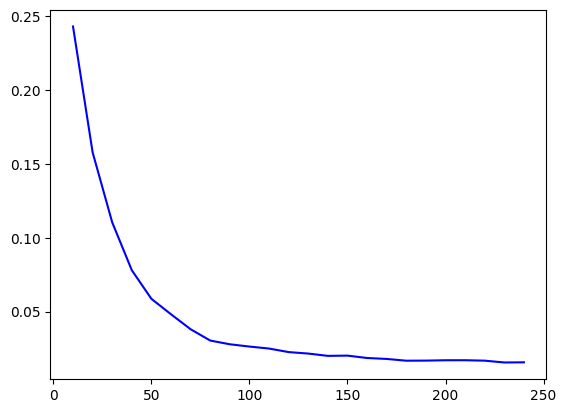

Epoch 240, loss 0.016, 13892.2 tokens/sec on cpu
Epoch 241, loss 0.016, 36058.1 tokens/sec on cpu
Epoch 242, loss 0.016, 33352.3 tokens/sec on cpu
Epoch 243, loss 0.016, 35104.1 tokens/sec on cpu
Epoch 244, loss 0.016, 32372.1 tokens/sec on cpu
Epoch 245, loss 0.016, 34531.6 tokens/sec on cpu
Epoch 246, loss 0.015, 35118.8 tokens/sec on cpu
Epoch 247, loss 0.015, 35049.3 tokens/sec on cpu
Epoch 248, loss 0.016, 36584.1 tokens/sec on cpu
Epoch 249, loss 0.016, 33143.4 tokens/sec on cpu


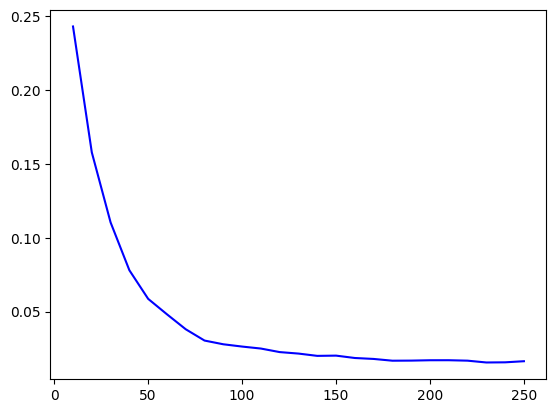

Epoch 250, loss 0.016, 14111.1 tokens/sec on cpu
Epoch 251, loss 0.016, 27574.7 tokens/sec on cpu
Epoch 252, loss 0.016, 32738.1 tokens/sec on cpu
Epoch 253, loss 0.016, 33439.1 tokens/sec on cpu
Epoch 254, loss 0.016, 36068.8 tokens/sec on cpu
Epoch 255, loss 0.015, 32486.6 tokens/sec on cpu
Epoch 256, loss 0.016, 37486.8 tokens/sec on cpu
Epoch 257, loss 0.017, 33804.2 tokens/sec on cpu
Epoch 258, loss 0.016, 35741.1 tokens/sec on cpu
Epoch 259, loss 0.016, 33297.6 tokens/sec on cpu


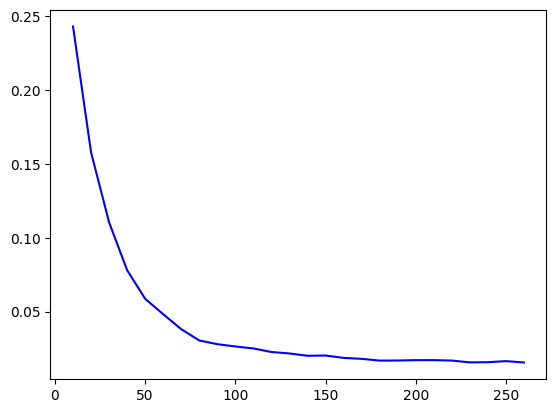

Epoch 260, loss 0.015, 14199.2 tokens/sec on cpu
Epoch 261, loss 0.016, 36624.6 tokens/sec on cpu
Epoch 262, loss 0.015, 35722.7 tokens/sec on cpu
Epoch 263, loss 0.016, 36689.7 tokens/sec on cpu
Epoch 264, loss 0.016, 34022.6 tokens/sec on cpu
Epoch 265, loss 0.016, 37918.6 tokens/sec on cpu
Epoch 266, loss 0.015, 34737.9 tokens/sec on cpu
Epoch 267, loss 0.016, 34760.2 tokens/sec on cpu
Epoch 268, loss 0.015, 35613.2 tokens/sec on cpu
Epoch 269, loss 0.016, 34988.3 tokens/sec on cpu


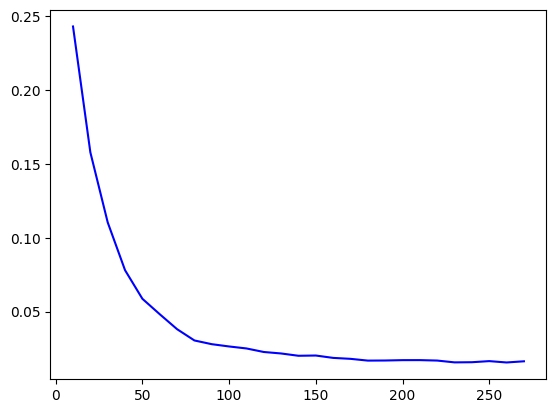

Epoch 270, loss 0.016, 14086.7 tokens/sec on cpu
Epoch 271, loss 0.016, 35921.3 tokens/sec on cpu
Epoch 272, loss 0.015, 35833.4 tokens/sec on cpu
Epoch 273, loss 0.016, 34879.1 tokens/sec on cpu
Epoch 274, loss 0.016, 37280.0 tokens/sec on cpu
Epoch 275, loss 0.016, 33419.6 tokens/sec on cpu
Epoch 276, loss 0.016, 34530.9 tokens/sec on cpu
Epoch 277, loss 0.016, 38729.0 tokens/sec on cpu
Epoch 278, loss 0.015, 36798.8 tokens/sec on cpu
Epoch 279, loss 0.015, 36588.5 tokens/sec on cpu


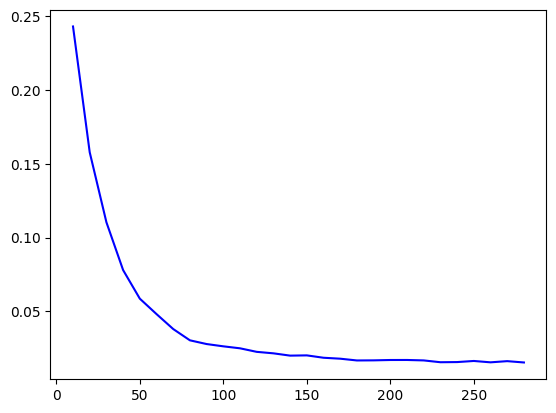

Epoch 280, loss 0.015, 13983.4 tokens/sec on cpu
Epoch 281, loss 0.015, 36398.9 tokens/sec on cpu
Epoch 282, loss 0.015, 39011.2 tokens/sec on cpu
Epoch 283, loss 0.015, 38952.0 tokens/sec on cpu
Epoch 284, loss 0.015, 34742.7 tokens/sec on cpu
Epoch 285, loss 0.015, 33569.0 tokens/sec on cpu
Epoch 286, loss 0.015, 37752.2 tokens/sec on cpu
Epoch 287, loss 0.016, 37013.2 tokens/sec on cpu
Epoch 288, loss 0.015, 34531.7 tokens/sec on cpu
Epoch 289, loss 0.016, 34847.7 tokens/sec on cpu


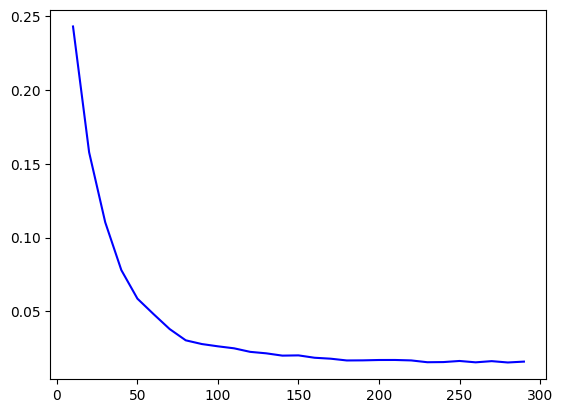

Epoch 290, loss 0.016, 14266.2 tokens/sec on cpu
Epoch 291, loss 0.015, 37495.3 tokens/sec on cpu
Epoch 292, loss 0.016, 38677.5 tokens/sec on cpu
Epoch 293, loss 0.015, 39180.1 tokens/sec on cpu
Epoch 294, loss 0.015, 36118.6 tokens/sec on cpu
Epoch 295, loss 0.015, 35977.3 tokens/sec on cpu
Epoch 296, loss 0.014, 35590.2 tokens/sec on cpu
Epoch 297, loss 0.014, 34715.2 tokens/sec on cpu
Epoch 298, loss 0.015, 36419.3 tokens/sec on cpu
Epoch 299, loss 0.015, 38937.2 tokens/sec on cpu


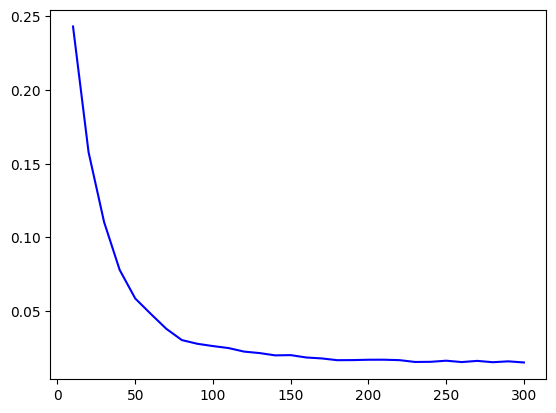

Epoch 300, loss 0.015, 14298.7 tokens/sec on cpu
Final loss: 0.015


In [290]:
embed_size, num_hiddens, num_layers, dropout = 64, 64, 2, 0.5
batch_size, num_steps = 64, 10
lr, num_epochs = 0.005, 300
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [291]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    '''	
    net: 训练好的 Encoder-Decoder 模型
	src_sentence: 源语言输入（字符串）
	src_vocab: 源语言词表
	tgt_vocab: 目标语言词表
	num_steps: 生成的最大长度
	device: 使用的设备（CPU/GPU）
	save_attention_weights: 是否保存注意力权重（可选）
    '''
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]  # 将句子分词、小写、映射成索引（token ID）, 添加 <eos> 表示结束
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0) # 增加 batch 维度（变成 shape: [1, num_steps]）
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0) # 目标句子的开始标志 <bos> 作为 decoder 第一个时间步的输入，一个形状为 (1, 1) 的 tensor
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps): 
        Y, dec_state = net.decoder(dec_X, dec_state) # 每一步拿 decoder 的输出 Y（shape: [1, 1, vocab_size]）进行预测
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2) # (1,1)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [292]:
# 按字tokenize
engs = ['a cat set on the mat']
predict_seq2seq(
        net, engs[0], src_vocab, tgt_vocab, num_steps, device)

engs = [
    "i love you .",
    "this is a book .",
    "do you speak english ?",
    "he is my friend .",
    "i am hungry ."
]

for eng in engs:
    translation, _ = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f"{eng} => {translation}")

i love you . => 我 爱 您 。
this is a book . => 這 是 個 <unk> <unk> 的 。
do you speak english ? => <unk> ？
he is my friend . => 他 很 <unk> 。
i am hungry . => 我 上 <unk> 了 。


In [230]:
# 按詞tokenize
engs = ['a cat set on the mat']
predict_seq2seq(
        net, engs[0], src_vocab, tgt_vocab, num_steps, device)

engs = [
    "i love you .",
    "this is a book .",
    "do you speak english ?",
    "he is my friend .",
    "i am hungry ."
]

for eng in engs:
    translation, _ = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f"{eng} => {translation}")

i love you . => 我 爱 您 。
this is a book . => 這是 <unk> <unk> 。
do you speak english ? => <unk> 嗎 ？
he is my friend . => 他 很 <unk> 。
i am hungry . => 我 沒事 。


In [209]:
import math
def bleu(pred_seq, label_seq, k):
    """计算BLEU
    pred_seq：模型预测的句子（字符串）
	label_seq：真实目标句子（ground truth）
	k：使用的最大 n-gram（如 1 表示 unigram，2 表示到 bigram）
    """
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1 # pred里面的减一，避免重复。
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n)) 
    return score

In [298]:
# 按字tokenize
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
chins = ['走 。', '我 迷 路 了 。', '他 很 冷 靜 。', '我 在 家 裡 。']
for eng, chin in zip(engs, chins):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, chin, k=2):.3f}')

go . => 没 问 题 ！, bleu 0.000
i lost . => 我 <unk> 失 了 它 ？, bleu 0.000
he's calm . => 他 很 開 <unk> 子 。, bleu 0.473
i'm home . => 我 在 家 裡 。, bleu 1.000


In [234]:
# 按詞tokenize
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
chins = ['走 吧 。', '我 迷路 了 。', '他 很 冷靜 。', '我 在家 裡 。']
for eng, chin in zip(engs, chins):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, chin, k=2):.3f}')

go . => 走 吧 。, bleu 1.000
i lost . => 我 <unk> 了 。, bleu 0.658
he's calm . => 他 很 进来 。, bleu 0.658
i'm home . => 我 在家 裡 。, bleu 1.000


In [66]:
!pip install jieba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 13.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314459 sha256=d9c078c940e3d0b0d1e03e87ad4ffddc6a307b6be48a40b41818f90955fe6444
  Stored in directory: /Users/dongwenou/Library/Caches/pip/wheels/08/a1/a3/5c8ac52cc2f5782ffffc34c95c57c8e5ecb3063dc69541ee7c
Successfully built jieba


We can see that the performance is much better when `jieba` tokenizer is used, including the `BLEU score` and the direct translation effect.